##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Read a PDF

This notebook demonstrates how you can convert a PDF file so that it can be read by the Gemini API.

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/PDF_Files.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## Setup

In [ ]:
%pip install -Uq 'google-genai>=1.0.0'

## Configure your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.

In [3]:
from google import genai
from google.colab import userdata

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

## Download and inspect the PDF

Install the PDF processing tools. You don't need these to use the API, it's just used to display a screenshot of a page.

In [4]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 0s (722 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


This PDF page is an article titled [Smoothly editing material properties of objects with text-to-image models and synthetic data](https://research.google/blog/smoothly-editing-material-properties-of-objects-with-text-to-image-models-and-synthetic-data/) available on the Google Research Blog.

In [5]:
import pathlib

if not pathlib.Path('test.pdf').exists():
  !curl -o test.pdf https://storage.googleapis.com/generativeai-downloads/data/Smoothly%20editing%20material%20properties%20of%20objects%20with%20text-to-image%20models%20and%20synthetic%20data.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6538k  100 6538k    0     0  29.6M      0 --:--:-- --:--:-- --:--:-- 29.6M


Look at one of the pages:

In [6]:
!pdftoppm test.pdf -f 1 -l 1 page-image -jpeg
!ls

page-image-1.jpg  sample_data  test.pdf


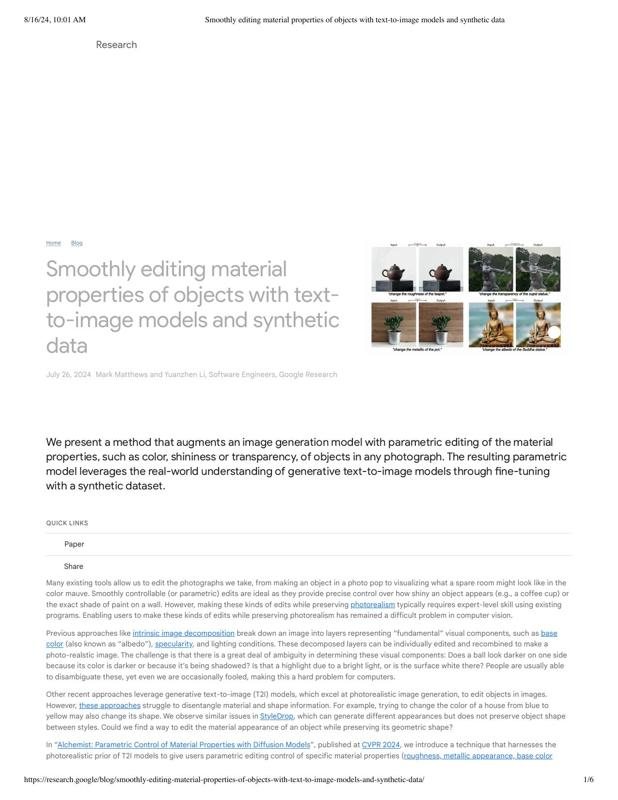

In [7]:
import PIL.Image

img = PIL.Image.open(f"page-image-1.jpg")
img.thumbnail([800, 800])
img

## Upload the file to the API

Start by uploading the PDF using the [File API](./File_API.ipynb).

In [8]:
file_ref = client.files.upload(file='test.pdf')

## Try it out

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](./Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).


In [9]:
MODEL_ID = "gemini-3-flash-preview" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro", "gemini-2.5-flash-preview", "gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}

The pages of the PDF file are each passed to the model as a screenshot of the page plus the text extracted by OCR.

In [10]:
client.models.count_tokens(
    model=MODEL_ID,
    contents=[file_ref, 'Can you summarize this file as a bulleted list?']
).total_tokens

1560

In [11]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[file_ref, 'Can you summarize this file as a bulleted list?']
)

In [12]:
from IPython.display import Markdown

Markdown(response.text)

Here's a summary of the document as a bulleted list:

*   **Problem Addressed:** The document introduces a new method to overcome the challenges of smoothly and photorealistically editing material properties (like color, shininess, or transparency) of objects in existing images, a task difficult for traditional tools and existing text-to-image (T2I) models which often struggle to disentangle material from shape.
*   **Proposed Solution:** Augmenting T2I models with parametric editing capabilities, leveraging synthetic data for fine-tuning. This work is detailed in their paper "Alchemist: Parametric Control of Material Properties with Diffusion Models" (CVPR 2024).
*   **Methodology:**
    *   A novel synthetic dataset was created using physically-based rendering of 100 3D household objects. For each "base image," a single material attribute (e.g., roughness, transparency) was varied with defined "edit strengths" (-1 for minimum change, +1 for maximum) while keeping object shape, lighting, and camera angle constant.
    *   A latent diffusion model (specifically, Stable Diffusion 1.5) was fine-tuned on this synthetic dataset. The model inputs include a context image, a text instruction (e.g., "change the metallic of the pot"), and a scalar edit strength.
    *   The model learns to edit only the specified material property and generalizes well from the synthetic data to real-world images.
*   **Results & Performance:**
    *   The method successfully changes object appearance (e.g., metallic, transparent) while preserving the object's shape and image lighting, realistically filling in backgrounds for transparent objects and showing caustic effects.
    *   A user study found their method produced more photorealistic edits (69.6% vs. 30.4%) and was strongly preferred (70.2% vs. 29.8%) compared to a baseline method (InstructPix2Pix).
*   **Applications:**
    *   Enables practical use cases like visualizing room changes, and rapid prototyping for architects, artists, and designers mocking up new product designs.
    *   The edits are visually consistent, allowing for integration with downstream 3D tasks, such as editing input images and then training a new NeRF (Neural Radiance Field) for 3D consistent renderings from new views.
*   **Conclusion:** The technique effectively leverages pre-trained T2I models and synthetic data for controllable, photorealistic material edits in images, demonstrating significant potential despite minor limitations with hidden details.

In addition, take a look at how the Gemini model responds when you ask questions about the images within the PDF.

In [13]:
response_2 = client.models.generate_content(
    model=MODEL_ID,
    contents=[file_ref, 'Can you explain the images on the first page of the document?']
)

In [14]:
Markdown(response_2.text)

The images on the first page of the document serve as the primary visual demonstration of the paper's core contribution: **smoothly editing material properties of objects in images using text prompts.**

Here's a breakdown of the four image pairs presented under the "Input" and "Output" headings:

1.  **Teapot Example (Top Left):**
    *   **Input:** Shows a smooth, brown teapot.
    *   **Prompt:** "change the roughness of the teapot."
    *   **Output:** The teapot now appears visibly rougher, with a less reflective, more matte surface, demonstrating the ability to control the "roughness" material property.

2.  **Cupid Statue Example (Top Right):**
    *   **Input:** Shows a solid, stone-like Cupid statue.
    *   **Prompt:** "change the transparency of the cupid statue."
    *   **Output:** The Cupid statue becomes transparent, revealing a blurred background behind it, showcasing control over the "transparency" material property.

3.  **Pot Example (Bottom Left):**
    *   **Input:** Shows a ceramic or earthenware pot.
    *   **Prompt:** "change the metallic of the pot."
    *   **Output:** The pot's surface transforms to appear highly metallic and reflective, demonstrating control over the "metallic" material property.

4.  **Buddha Statue Example (Bottom Right):**
    *   **Input:** Shows a golden Buddha statue.
    *   **Prompt:** "change the albedo of the Buddha statue."
    *   **Output:** The Buddha statue changes its base color (albedo) to a lighter, possibly marble-like or white stone appearance, illustrating the ability to modify the "albedo" (base color) material property.

In summary, these images vividly illustrate how the proposed method takes an original photograph (Input), interprets a natural language instruction (Prompt) for a specific object within it, and then realistically alters a particular material property of that object (Output) while preserving its overall shape, pose, and the lighting conditions of the scene.

If you observe the area of the header of the article, you can see that the model captures what is happening.

## Learning more

The File API lets you upload a variety of multimodal MIME types, including images, audio, and video formats. The File API handles inputs that can be used to generate content with `model.generateContent` or `model.streamGenerateContent`.

The File API accepts files under 2GB in size and can store up to 20GB of files per project. Files last for 2 days and cannot be downloaded from the API.

* Learn more about prompting with [media files](https://ai.google.dev/gemini-api/docs/file-prompting-strategies) in the docs, including the supported formats and maximum length.
* Learn more about to extract structured outputs from PDFs in the [Structured outputs on invoices and forms](https://github.com/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb) example.
